<a href="https://colab.research.google.com/github/appliedcode/mthree-c422/blob/main/Exercises/day-13/Bias/Bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***

# Practice Exercise Set: Understanding Bias in Algorithms

This set focuses on exploring data, algorithmic, and societal bias, methods to detect and mitigate bias, and applying fairness metrics to evaluate models.

***

## 1. Types of Bias in Algorithms

### Exercise 1.1 — Explore Types of Bias (Conceptual)

- **Data Bias:** Bias arising from unrepresentative or skewed datasets (e.g., selection bias, sampling bias).
- **Algorithmic Bias:** Bias introduced by model choices or design (e.g., feature selection bias, inductive bias).
- **Societal Bias:** Pre-existing societal inequalities reflected in data and models (e.g., historical discrimination, stereotype bias).


### Exercise 1.2 — Identify Bias Sources

- Given a dataset of loan applications with demographic attributes, reflect on possible sources of each bias type. For example, data bias may come from under-sampling minorities, algorithm bias from model ignoring fairness, and societal bias from systemic economic disparities.

*(This task is primarily conceptual and discussion-based.)*

***

## 2. Techniques for Detecting Bias

We’ll use a synthetic loan dataset for hands-on detection.

### Exercise 2.1 — Data Bias Detection

- Analyze demographic group distribution and label imbalance.
- Perform chi-square test for independence.
- Visualize approval rates by groups.

Ethnicity
Group_A    0.481
Group_B    0.294
Group_C    0.225
Name: proportion, dtype: float64
Ethnicity
Group_A    0.704782
Group_B    0.421769
Group_C    0.457778
Name: Loan_Approved, dtype: float64
Chi-square test p-value: 1.1871666628169174e-16


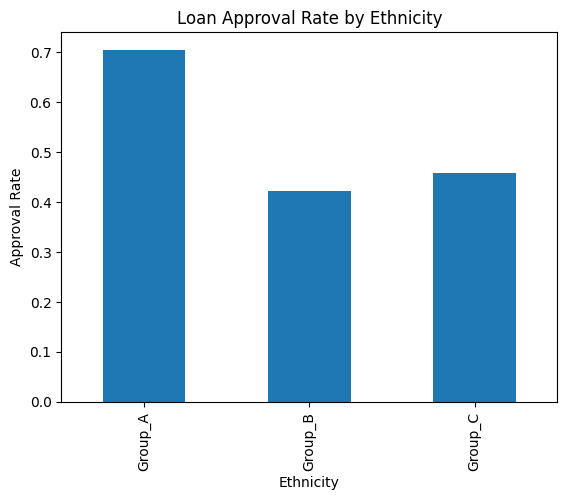

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Generate synthetic data
np.random.seed(0)
n = 1000
genders = ['Male', 'Female']
ethnicities = ['Group_A', 'Group_B', 'Group_C']

data = pd.DataFrame({
    'Gender': np.random.choice(genders, n, p=[0.6, 0.4]),
    'Ethnicity': np.random.choice(ethnicities, n, p=[0.5, 0.3, 0.2])
})

# Simulated loan approvals with bias: Group_A has higher approval rate
data['Loan_Approved'] = np.where(
    (data['Ethnicity'] == 'Group_A'),
    np.random.choice([1, 0], n, p=[0.7, 0.3]),
    np.random.choice([1, 0], n, p=[0.4, 0.6])
)

# Group distribution
print(data['Ethnicity'].value_counts(normalize=True))

# Approval rates by Ethnicity
approval_rates = data.groupby('Ethnicity')['Loan_Approved'].mean()
print(approval_rates)

# Chi-square test
contingency_table = pd.crosstab(data['Ethnicity'], data['Loan_Approved'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square test p-value: {p}")

# Bar plot
approval_rates.plot(kind='bar', title='Loan Approval Rate by Ethnicity')
plt.ylabel('Approval Rate')
plt.show()

### Explanation:

- Imbalanced group sizes and differing approval rates indicate potential data bias.
- A small p-value from chi-square suggests approval depends on ethnicity.

***

### Exercise 2.2 — Algorithmic Bias Detection

- Train a baseline classifier (e.g. logistic regression).
- Compute accuracy, True Positive Rate (TPR), False Positive Rate (FPR) per group.
- Check feature importance for sensitive attributes.



In [52]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Prepare data
X = pd.get_dummies(data[['Gender', 'Ethnicity']], drop_first=True)
y = data['Loan_Approved']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Group-wise metrics function
def group_metrics(df, labels, preds, group_col):
    results = {}
    for g in df[group_col].unique():
        idx = df[group_col]==g
        tn, fp, fn, tp = confusion_matrix(labels[idx], preds[idx]).ravel()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        acc = (tp + tn) / (tp + tn + fp + fn)
        results[g] = {'Accuracy': acc, 'TPR': tpr, 'FPR': fpr}
    return pd.DataFrame(results)

df_test = X_test.copy()
df_test['Gender'] = data.loc[y_test.index, 'Gender'].values
df_test['Ethnicity'] = data.loc[y_test.index, 'Ethnicity'].values

metrics_gender = group_metrics(df_test, y_test, y_pred, 'Gender')
metrics_ethnicity = group_metrics(df_test, y_test, y_pred, 'Ethnicity')

print("Metrics by Gender:")
print(metrics_gender)
print("\nMetrics by Ethnicity:")
print(metrics_ethnicity)

# Feature importance (coefficients)
coef = pd.Series(model.coef_[0], index=X.columns)
print("\nFeature importance:")
print(coef.sort_values(ascending=False))

Metrics by Gender:
              Male    Female
Accuracy  0.652850  0.682243
TPR       0.605263  0.566667
FPR       0.278481  0.170213

Metrics by Ethnicity:
           Group_C   Group_B   Group_A
Accuracy  0.513514  0.623656  0.774436
TPR       0.000000  0.000000  1.000000
FPR       0.000000  0.000000  1.000000

Feature importance:
Gender_Male         -0.202833
Ethnicity_Group_B   -0.917951
Ethnicity_Group_C   -0.923650
dtype: float64


### Explanation:

- Examine if performance metrics differ substantially between groups.
- Large differences in TPR or FPR indicate algorithmic bias.
- Sensitive features with large coefficients may drive bias.

***

## 3. Techniques for Mitigating Bias

### Exercise 3.1 — Pre-processing: Re-sampling to Balance Dataset

In [53]:
from sklearn.utils import resample

# Resample minority group to balance dataset
df_minority = data[data['Ethnicity']=='Group_C']
df_majority = data[data['Ethnicity']!='Group_C']

df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)

df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Recheck approval rates
print(df_balanced['Ethnicity'].value_counts(normalize=True))
print(df_balanced.groupby('Ethnicity')['Loan_Approved'].mean())

Ethnicity
Group_C    0.500000
Group_A    0.310323
Group_B    0.189677
Name: proportion, dtype: float64
Ethnicity
Group_A    0.704782
Group_B    0.421769
Group_C    0.441290
Name: Loan_Approved, dtype: float64


### Exercise 3.2 — In-processing: Train with Fairness Constraint (Sample for illustration)

- Implement fairness constraints if toolkits like `aif360` or other libraries are available (not shown here for simplicity).


### Exercise 3.3 — Post-processing: Adjust Decision Thresholds per Group

In [54]:
# Example: Compute thresholds to equalize TPR or FPR (high level exercise)
# Requires predicted probabilities and per-group ROC curves (not shown due to complexity)

***

## 4. Fairness Metrics and Evaluation

### Exercise 4.1 — Compute Common Fairness Metrics

In [55]:
def demographic_parity(y_true, y_pred, group):
    rates = pd.DataFrame({'y_pred': y_pred, 'group': group}).groupby('group')['y_pred'].mean()
    return rates.max() - rates.min()

def equal_opportunity(y_true, y_pred, group):
    results = {}
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'group': group})
    for g in df['group'].unique():
        subset = df[df['group'] == g]
        tp = ((subset['y_pred'] == 1) & (subset['y_true'] == 1)).sum()
        fn = ((subset['y_pred'] == 0) & (subset['y_true'] == 1)).sum()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        results[g] = tpr
    tpr_vals = list(results.values())
    return max(tpr_vals) - min(tpr_vals)

dp_ethnicity = demographic_parity(y_test, y_pred, df_test['Ethnicity'])
eo_ethnicity = equal_opportunity(y_test, y_pred, df_test['Ethnicity'])

print(f"Demographic Parity Difference (Ethnicity): {dp_ethnicity:.3f}")
print(f"Equal Opportunity Difference (Ethnicity): {eo_ethnicity:.3f}")

Demographic Parity Difference (Ethnicity): 1.000
Equal Opportunity Difference (Ethnicity): 1.000


### Exercise 4.2 — Compare Before/After Mitigation

- Repeat model training and metric calculation on balanced data and compare fairness results.


### Exercise 4.3 — Discussion

- Reflect on how accuracy may trade off with fairness.
- Consider how mitigations affect model complexity or interpretability.

***